# Этап 1. Подготовительный этап

In [1]:
!pip install tensorflow-datasets tensorflow-text nltk matplotlib > /dev/null
print("Библиотеки установлены")

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
print(f"GPU обнаружено: {len(gpus)}")
if gpus:
    print(f"Тип GPU: T4 (16GB памяти)")

Библиотеки установлены
GPU обнаружено: 1
Тип GPU: T4 (16GB памяти)


Импорт библиотек

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_text as text
import numpy as np
import os
import json
import time
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import warnings
warnings.filterwarnings('ignore')

print("Все библиотеки загружены")
print(f"TensorFlow version: {tf.__version__}")

Все библиотеки загружены
TensorFlow version: 2.19.0


Загрузка дата сета

In [3]:
examples, metadata = tfds.load(
    'ted_hrlr_translate/pt_to_en',
    with_info=True,
    as_supervised=True
)

print("Датасет загружен")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.646YXE_1.0.0/ted_hrlr_translate-tra…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.646YXE_1.0.0/ted_hrlr_translate-val…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/incomplete.646YXE_1.0.0/ted_hrlr_translate-tes…

Dataset ted_hrlr_translate downloaded and prepared to /root/tensorflow_datasets/ted_hrlr_translate/pt_to_en/1.0.0. Subsequent calls will reuse this data.
Датасет загружен


Обучающий и тестовый наборы

In [4]:
train_examples, val_examples = examples['train'], examples['validation']
print(f"Размер обучающего набора: {len(list(train_examples))} примеров")
print(f"Размер тестового набора: {len(list(val_examples))} примеров")

Размер обучающего набора: 51785 примеров
Размер тестового набора: 1193 примеров


Примеры данных

In [5]:
for pt_example, en_example in train_examples.take(2):
    print("🇵🇹 Португальский:", pt_example.numpy().decode('utf-8'))
    print("🇬🇧 Английский:", en_example.numpy().decode('utf-8'))
    print("-" * 50)

🇵🇹 Португальский: e quando melhoramos a procura , tiramos a única vantagem da impressão , que é a serendipidade .
🇬🇧 Английский: and when you improve searchability , you actually take away the one advantage of print , which is serendipity .
--------------------------------------------------
🇵🇹 Португальский: mas e se estes fatores fossem ativos ?
🇬🇧 Английский: but what if it were active ?
--------------------------------------------------


Загрузка токенизатора

In [6]:
model_name = 'ted_hrlr_translate_pt_en_converter'

downloaded_path = tf.keras.utils.get_file(
    f'{model_name}.zip',
    f'https://storage.googleapis.com/download.tensorflow.org/models/{model_name}.zip',
    cache_dir='.', cache_subdir='', extract=True
)
print(f"Архив скачан в: {downloaded_path}")

# Определяем нужный путь
!find / -name "*ted_hrlr_translate_pt_en_converter*" -type d 2>/dev/null | head -5

184801/184801 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Архив скачан в: ./ted_hrlr_translate_pt_en_converter_extracted
/content/ted_hrlr_translate_pt_en_converter_extracted
/content/ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter


In [7]:
# Указываем путь, найденный командой find
extracted_folder_path = '/content/ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter'

print(f"Пытаюсь загрузить модель из: {extracted_folder_path}")

# Проверяем, существует ли путь, прежде чем загружать
if os.path.exists(extracted_folder_path):
    print("Папка с моделью найдена")
    tokenizers = tf.saved_model.load(extracted_folder_path)
    print("Токенизатор успешно загружен")
    print(f"Размер словаря португальского: {tokenizers.pt.get_vocab_size().numpy()}")
    print(f"Размер словаря английского: {tokenizers.en.get_vocab_size().numpy()}")

else:
    print(f"Ошибка: Папка по пути '{extracted_folder_path}' не найдена.")
    print("Содержимое родительской директории /content:")
    !ls -la /content/

Пытаюсь загрузить модель из: /content/ted_hrlr_translate_pt_en_converter_extracted/ted_hrlr_translate_pt_en_converter
Папка с моделью найдена
Токенизатор успешно загружен
Размер словаря португальского: 7765
Размер словаря английского: 7010


Тестируем токенизатор

In [8]:
sample_pt = "Olá, mundo!"
sample_en = "Hello, world!"

print("Пример токенизации:")
print(f"Португальский: {sample_pt}")
pt_tokens = tokenizers.pt.tokenize([sample_pt])
print(f"Токены PT: {pt_tokens.to_list()[0][:10]}...")
print(f"Обратно: {tokenizers.pt.detokenize(pt_tokens).numpy()[0].decode('utf-8')}")

print(f"\nАнглийский: {sample_en}")
en_tokens = tokenizers.en.tokenize([sample_en])
print(f"Токены EN: {en_tokens.to_list()[0][:10]}...")
print(f"Обратно: {tokenizers.en.detokenize(en_tokens).numpy()[0].decode('utf-8')}")

Пример токенизации:
Португальский: Olá, mundo!
Токены PT: [2, 1616, 14, 136, 4, 3]...
Обратно: ola , mundo !

Английский: Hello, world!
Токены EN: [2, 4006, 13, 143, 4, 3]...
Обратно: hello , world !


Подготовка функции для батчей

In [9]:
def prepare_batch(pt, en):
    pt = tokenizers.pt.tokenize(pt)     # Токенизируем португальский
    pt = pt.to_tensor()                  # Преобразуем в тензор

    en = tokenizers.en.tokenize(en)     # Токенизируем английский
    en = en.to_tensor()                  # Преобразуем в тензор

    # Для декодера: сдвиг на один токен
    en_inputs = en[:, :-1]              # Вход декодера (без последнего токена)
    en_labels = en[:, 1:]               # Цель декодера (без первого токена)

    return (pt, en_inputs), en_labels

def make_batches(ds, buffer_size=20000, batch_size=32):
    return (
        ds
        .shuffle(buffer_size)
        .batch(batch_size)
        .map(prepare_batch, tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )

print("Функции подготовлены")

Функции подготовлены


Создание батчей с оптимизацией для Т4

In [10]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

print(f"Создание батчей с параметрами:")
print(f"  BATCH_SIZE = {BATCH_SIZE} (оптимально для T4)")
print(f"  BUFFER_SIZE = {BUFFER_SIZE}")

train_batches = make_batches(train_examples, BUFFER_SIZE, BATCH_SIZE)
val_batches = make_batches(val_examples, BUFFER_SIZE, BATCH_SIZE)

# Проверяем размеры
for (pt, en), en_labels in train_batches.take(1):
    print(f"\nБатчи созданы")
    print(f"Размерность португальского: {pt.shape}")
    print(f"Размерность английского (вход): {en.shape}")
    print(f"Размерность английского (цель): {en_labels.shape}")
    print(f"Пример: {pt.shape[1]} токенов на языке-источнике")

Создание батчей с параметрами:
  BATCH_SIZE = 64 (оптимально для T4)
  BUFFER_SIZE = 20000

Батчи созданы
Размерность португальского: (64, 74)
Размерность английского (вход): (64, 73)
Размерность английского (цель): (64, 73)
Пример: 74 токенов на языке-источнике


Создание структуры проекта

In [11]:
folders = [
    'transformer_checkpoints',
    'saved_models',
    'training_results',
    'attention_viz',
    'translation_examples'
]

for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
        print(f" Создана: {folder}/")
    else:
        print(f" Уже существует: {folder}/")

print("\nСтруктура проекта готова")

 Создана: transformer_checkpoints/
 Создана: saved_models/
 Создана: training_results/
 Создана: attention_viz/
 Создана: translation_examples/

Структура проекта готова


Сохранение конфига

In [12]:
config = {
    'batch_size': BATCH_SIZE,
    'vocab_size_pt': int(tokenizers.pt.get_vocab_size().numpy()),  # <-- Добавляем int()
    'vocab_size_en': int(tokenizers.en.get_vocab_size().numpy()),  # <-- Добавляем int()
    'dataset_size_train': len(list(train_examples)),
    'dataset_size_val': len(list(val_examples)),
    'gpu_type': 'NVIDIA T4 (16GB)',
    'tensorflow_version': tf.__version__,
    'project_name': 'Portuguese to English Transformer',
    'date_created': time.strftime("%Y-%m-%d %H:%M:%S")
}

# Сохраняем в файл
with open('project_config.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, indent=2, ensure_ascii=False)

print("КОНФИГУРАЦИЯ ПРОЕКТА:")
for key, value in config.items():
    print(f"{key:25}: {value}")

print("\nКонфигурация сохранена в 'project_config.json'")

КОНФИГУРАЦИЯ ПРОЕКТА:
batch_size               : 64
vocab_size_pt            : 7765
vocab_size_en            : 7010
dataset_size_train       : 51785
dataset_size_val         : 1193
gpu_type                 : NVIDIA T4 (16GB)
tensorflow_version       : 2.19.0
project_name             : Portuguese to English Transformer
date_created             : 2025-12-22 16:22:01

Конфигурация сохранена в 'project_config.json'


# Этап 2. Реализация архитектуры трансформер

Positional Encoding (Позиционное кодирование)

In [13]:
class PositionalEncoding(tf.keras.layers.Layer):
    """
    Позиционное кодирование для передачи информации о порядке слов.
    Использует синусоидальные функции разных частот.
    """
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.position = position
        self.d_model = d_model

        # Создаем матрицу позиционного кодирования заранее
        pos_encoding = np.zeros((position, d_model))

        # positions.shape: (position, 1)
        positions = np.arange(position)[:, np.newaxis]

        # div_term.shape: (d_model//2,)
        # Используем формулу из статьи: PE(pos, 2i) = sin(pos/10000^(2i/d_model))
        div_term = np.exp(np.arange(0, d_model, 2) * -(np.log(10000.0) / d_model))

        # Применяем синус к четным индексам
        pos_encoding[:, 0::2] = np.sin(positions * div_term)
        # Применяем косинус к нечетным индексам
        pos_encoding[:, 1::2] = np.cos(positions * div_term)

        # Преобразуем в тензор и добавляем размерность батча
        pos_encoding = pos_encoding[np.newaxis, ...]

        # Сохраняем как вес слоя (не обучаемый)
        self.pos_encoding = tf.constant(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        """
        inputs: тензор формы (batch_size, seq_len, d_model)
        Возвращает: inputs + позиционное кодирование
        """
        # Берем только первые seq_len позиций
        seq_len = tf.shape(inputs)[1]
        return inputs + self.pos_encoding[:, :seq_len, :]

# Тестируем PositionalEncoding
print("Тест Positional Encoding")
d_model = 512  # Размерность модели (как в оригинальной статье)
position = 1000  # Максимальная длина последовательности

pos_encoding_layer = PositionalEncoding(position, d_model)

# Создаем тестовый эмбеддинг (например, для батча из 2 примеров длиной 10)
test_input = tf.random.uniform((2, 10, d_model))
output = pos_encoding_layer(test_input)

print(f"Positional Encoding работает")
print(f"   Входная форма: {test_input.shape}")
print(f"   Выходная форма: {output.shape}")
print(f"   Типичные значения: min={tf.reduce_min(output):.4f}, max={tf.reduce_max(output):.4f}")

Тест Positional Encoding
Positional Encoding работает
   Входная форма: (2, 10, 512)
   Выходная форма: (2, 10, 512)
   Типичные значения: min=-0.9748, max=1.9997


Multi-Head Attention (Многоголовое внимание)

In [14]:
def scaled_dot_product_attention(query, key, value, mask):
    """
    Вычисление scaled dot-product attention.
    query, key, value: тензоры формы (..., seq_len_q, d_model)
    mask: тензор формы (..., seq_len_q, seq_len_k)
    """
    # 1. Умножаем query на key
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 2. Масштабируем
    dk = tf.cast(tf.shape(key)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # 3. Применяем маску (если есть)
    if mask is not None:
        # Добавляем очень маленькое значение к маскированным позициям
        scaled_attention_logits += (mask * -1e9)

    # 4. Применяем softmax для получения весов внимания
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # 5. Умножаем на value
    output = tf.matmul(attention_weights, value)

    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Слой многоголового внимания.
    Разделяет d_model на h голов, применяет внимание к каждой, затем объединяет.
    """
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % num_heads == 0, "d_model должно делиться на num_heads"

        self.depth = d_model // num_heads  # Размерность каждой головы

        # Линейные слои для query, key, value
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        # Финальный линейный слой
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """
        Разделяет последнюю размерность на (num_heads, depth).
        Транспонирует результат к форме (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        # 1. Применяем линейные преобразования
        q = self.wq(q)  # (batch_size, seq_len_q, d_model)
        k = self.wk(k)  # (batch_size, seq_len_k, d_model)
        v = self.wv(v)  # (batch_size, seq_len_v, d_model)

        # 2. Разделяем на головы
        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        # 3. Вычисляем scaled dot-product attention
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask
        )  # scaled_attention: (batch_size, num_heads, seq_len_q, depth)

        # 4. Объединяем головы
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # 5. Применяем финальный линейный слой
        output = self.dense(concat_attention)

        return output, attention_weights

# Тестируем MultiHeadAttention
print("\nТест Multi-Head Attention")
num_heads = 8

# Создаем тестовые данные
batch_size = 2
seq_len = 10
test_q = tf.random.uniform((batch_size, seq_len, d_model))
test_k = tf.random.uniform((batch_size, seq_len, d_model))
test_v = tf.random.uniform((batch_size, seq_len, d_model))

# Создаем слой внимания
mha = MultiHeadAttention(d_model, num_heads)
output, attention_weights = mha(test_v, test_k, test_q, mask=None)

print(f"Multi-Head Attention работает")
print(f"   Query форма: {test_q.shape}")
print(f"   Output форма: {output.shape}")
print(f"   Attention weights форма: {attention_weights.shape}")


Тест Multi-Head Attention
Multi-Head Attention работает
   Query форма: (2, 10, 512)
   Output форма: (2, 10, 512)
   Attention weights форма: (2, 8, 10, 10)


Построение Encoder и Decoder слоев

In [15]:
def point_wise_feed_forward_network(d_model, dff):
    """
    Точечная feed-forward сеть (по-элементно применяется к каждой позиции).
    Состоит из двух линейных слоев с активацией ReLU между ними.
    """
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),  # Первый слой (расширение)
        tf.keras.layers.Dense(d_model)  # Второй слой (проекция обратно в d_model)
    ])

class EncoderLayer(tf.keras.layers.Layer):
    """Один слой Encoder'а: Self-Attention + Feed Forward"""
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Layer Normalization для стабилизации обучения
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout для регуляризации
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # 1. Self-Attention с residual connection
        attn_output, _ = self.mha(x, x, x, mask)  # Self-attention: Q=K=V=x
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # Residual connection

        # 2. Feed Forward Network с residual connection
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # Residual connection

        return out2

class DecoderLayer(tf.keras.layers.Layer):
    """Один слой Decoder'а: Masked Self-Attention + Encoder-Decoder Attention + FFN"""
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        # Masked Self-Attention (маскированное самовнимание)
        self.mha1 = MultiHeadAttention(d_model, num_heads)

        # Encoder-Decoder Attention (внимание к выходу encoder'а)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        # Feed Forward Network
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        # Layer Normalization
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        # Dropout
        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        # enc_output.shape: (batch_size, input_seq_len, d_model)

        # 1. Masked Self-Attention (с look_ahead_mask)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)  # Residual connection

        # 2. Encoder-Decoder Attention (с padding_mask)
        # Q из decoder, K и V из encoder
        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1, padding_mask
        )
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # Residual connection

        # 3. Feed Forward Network
        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # Residual connection

        return out3, attn_weights_block1, attn_weights_block2

# Тестируем EncoderLayer и DecoderLayer
print("\nТест EncoderLayer и DecoderLayer")
dff = 2048  # Размер скрытого слоя FFN (как в оригинальной статье)
dropout_rate = 0.1

# Создаем тестовые данные
batch_size = 2
seq_len = 10
test_encoder_input = tf.random.uniform((batch_size, seq_len, d_model))
test_decoder_input = tf.random.uniform((batch_size, seq_len, d_model))

# Создаем слои
encoder_layer = EncoderLayer(d_model, num_heads, dff, dropout_rate)
decoder_layer = DecoderLayer(d_model, num_heads, dff, dropout_rate)

# Пропускаем через encoder
encoder_output = encoder_layer(test_encoder_input, training=True, mask=None)

# Пропускаем через decoder
decoder_output, attn1, attn2 = decoder_layer(
    test_decoder_input, encoder_output, training=True,
    look_ahead_mask=None, padding_mask=None
)

print(f"EncoderLayer работает")
print(f"   Вход encoder: {test_encoder_input.shape}")
print(f"   Выход encoder: {encoder_output.shape}")

print(f"\nDecoderLayer работает")
print(f"   Вход decoder: {test_decoder_input.shape}")
print(f"   Выход decoder: {decoder_output.shape}")
print(f"   Attention weights 1: {attn1.shape}")
print(f"   Attention weights 2: {attn2.shape}")


Тест EncoderLayer и DecoderLayer
EncoderLayer работает
   Вход encoder: (2, 10, 512)
   Выход encoder: (2, 10, 512)

DecoderLayer работает
   Вход decoder: (2, 10, 512)
   Выход decoder: (2, 10, 512)
   Attention weights 1: (2, 8, 10, 10)
   Attention weights 2: (2, 8, 10, 10)


Сборка полной модели Transformer

In [16]:
class Encoder(tf.keras.layers.Layer):
    """Полный Encoder: embedding + positional encoding + N слоев encoder"""
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Encoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding слой (преобразование токенов в векторы)
        self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)

        # Positional Encoding
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        # Стек слоев Encoder
        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]

        # Dropout после embedding + positional encoding
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training=False, mask=None):  # <-- Добавляем значения по умолчанию
        seq_len = tf.shape(x)[1]

        # 1. Добавляем embedding
        x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Масштабируем

        # 2. Добавляем positional encoding
        x = self.pos_encoding(x)

        # 3. Применяем dropout
        x = self.dropout(x, training=training)

        # 4. Пропускаем через все слои encoder
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training, mask=mask)

        return x  # (batch_size, input_seq_len, d_model)

class Decoder(tf.keras.layers.Layer):
    """Полный Decoder: embedding + positional encoding + N слоев decoder"""
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
                 maximum_position_encoding, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        # Embedding слой
        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)

        # Positional Encoding
        self.pos_encoding = PositionalEncoding(maximum_position_encoding, d_model)

        # Стек слоев Decoder
        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                          for _ in range(num_layers)]

        # Dropout после embedding + positional encoding
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training=False, look_ahead_mask=None, padding_mask=None):  # <-- Добавляем значения по умолчанию
        seq_len = tf.shape(x)[1]
        attention_weights = {}  # Сохраняем веса внимания для визуализации

        # 1. Добавляем embedding
        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))  # Масштабируем

        # 2. Добавляем positional encoding
        x = self.pos_encoding(x)

        # 3. Применяем dropout
        x = self.dropout(x, training=training)

        # 4. Пропускаем через все слои decoder
        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](
                x, enc_output, training=training,
                look_ahead_mask=look_ahead_mask,
                padding_mask=padding_mask
            )

            # Сохраняем веса внимания для визуализации
            attention_weights[f'decoder_layer{i+1}_block1'] = block1
            attention_weights[f'decoder_layer{i+1}_block2'] = block2

        return x, attention_weights

class Transformer(tf.keras.Model):
    """Полная модель Transformer"""
    def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
                 target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()

        # Encoder
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,
                              input_vocab_size, pe_input, rate)

        # Decoder
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,
                              target_vocab_size, pe_target, rate)

        # Финальный линейный слой (преобразование в вероятности слов)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inputs, training=False):
        # inputs: кортеж (inp, tar)
        inp, tar = inputs

        # ИСПРАВЛЕНИЕ: создаем маски с правильными длинами
        enc_padding_mask = self.create_padding_mask(inp)

        # look_ahead_mask для tar (входа декодера)
        look_ahead_mask = self.create_look_ahead_mask(tf.shape(tar)[1])

        # padding_mask для декодера (используем ту же, что и для encoder)
        dec_padding_mask = self.create_padding_mask(inp)

        # 1. Пропускаем через encoder
        enc_output = self.encoder(inp, training=training, mask=enc_padding_mask)

        # 2. Пропускаем через decoder
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training=training,
            look_ahead_mask=look_ahead_mask,
            padding_mask=dec_padding_mask
        )

        # 3. Финальный линейный слой
        final_output = self.final_layer(dec_output)

        return final_output, attention_weights

    def create_padding_mask(self, seq):
        """Создает маску для padding токенов (значение 1 для padding)"""
        seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
        return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

    def create_look_ahead_mask(self, size):
        """Создает маску для предотвращения заглядывания в будущее в decoder"""
        mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
        return mask  # (size, size)

Тест полной модели

In [17]:
# Параметры модели (как в оригинальной статье, но уменьшены для теста)
num_layers = 4  # В оригинале: 6
input_vocab_size = config['vocab_size_pt']  # Берем из сохраненной конфигурации
target_vocab_size = config['vocab_size_en']
pe_input = 1000
pe_target = 1000

# Создаем модель
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=input_vocab_size,
    target_vocab_size=target_vocab_size,
    pe_input=pe_input,
    pe_target=pe_target,
    rate=dropout_rate
)

# Создаем тестовые данные
temp_input = tf.random.uniform((BATCH_SIZE, 10), maxval=input_vocab_size, dtype=tf.int64)
temp_target = tf.random.uniform((BATCH_SIZE, 12), maxval=target_vocab_size, dtype=tf.int64)

# Пропускаем через модель (ОБРАТИТЕ ВНИМАНИЕ: training передается как именованный аргумент)
fn_out, attention_weights = transformer((temp_input, temp_target), training=True)

print(f"Полная модель Transformer создана")
print(f"   Вход encoder (португальский): {temp_input.shape}")
print(f"   Вход decoder (английский): {temp_target.shape}")
print(f"   Выход модели (логиты): {fn_out.shape}")
print(f"   Количество весов внимания: {len(attention_weights)}")

# Покажем форму первого блока внимания
first_key = list(attention_weights.keys())[0]
print(f"   Форма {first_key}: {attention_weights[first_key].shape}")

# Проверяем количество параметров модели
total_params = transformer.count_params()
print(f"\nСтатистика модели:")
print(f"   Количество параметров: {total_params:,}")
print(f"   Размерность модели (d_model): {d_model}")
print(f"   Количество слоев: {num_layers}")
print(f"   Количество голов внимания: {num_heads}")

# Дополнительная проверка в режиме inference (без обучения)
print(f"\nТест в режиме inference (training=False):")
fn_out_inference, _ = transformer((temp_input, temp_target), training=False)
print(f"   Выход в inference режиме: {fn_out_inference.shape}")

Полная модель Transformer создана
   Вход encoder (португальский): (64, 10)
   Вход decoder (английский): (64, 12)
   Выход модели (логиты): (64, 12, 7010)
   Количество весов внимания: 8
   Форма decoder_layer1_block1: (64, 8, 12, 12)

Статистика модели:
   Количество параметров: 40,586,594
   Размерность модели (d_model): 512
   Количество слоев: 4
   Количество голов внимания: 8

Тест в режиме inference (training=False):
   Выход в inference режиме: (64, 12, 7010)


# Этап 3. Обучение модели трансформер

Настройка процесса обучения


1. Настройка learning rate schedule
   Оптимизатор: Adam с CustomSchedule
   Начальный learning rate: 0.000000
   Learning rate после 4000 шагов: 0.000699


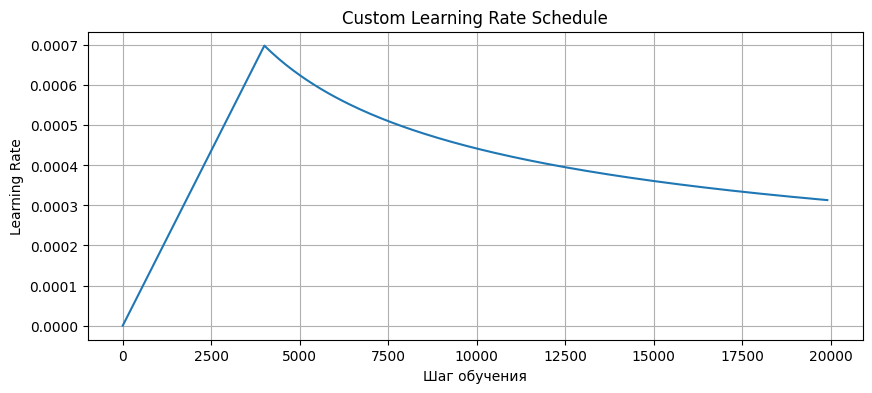

График сохранен в 'training_results/learning_rate_schedule.png'

2. Настройка функции потерь и метрик
   Функция потерь: Sparse Categorical Crossentropy с маскированием
   Метрика точности: Sparse Categorical Accuracy

3. Настройка системы чекпоинтов
Чекпоинты не найдены, начинаем обучение с нуля


In [18]:
# 1. Кастомный schedule для learning rate (как в оригинальной статье)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    """
    Кастомный schedule для learning rate по формуле из статьи "Attention Is All You Need":
    lr = d_model^(-0.5) * min(step_num^(-0.5), step_num * warmup_steps^(-1.5))
    """
    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        lr = tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
        return lr

# 2. Визуализация schedule
print("\n1. Настройка learning rate schedule")
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(
    learning_rate,
    beta_1=0.9,
    beta_2=0.98,
    epsilon=1e-9
)

print(f"   Оптимизатор: Adam с CustomSchedule")
print(f"   Начальный learning rate: {learning_rate(0).numpy():.6f}")
print(f"   Learning rate после 4000 шагов: {learning_rate(4000).numpy():.6f}")

# График learning rate
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
steps = range(0, 20000, 100)
lrs = [learning_rate(step).numpy() for step in steps]
plt.plot(steps, lrs)
plt.xlabel('Шаг обучения')
plt.ylabel('Learning Rate')
plt.title('Custom Learning Rate Schedule')
plt.grid(True)
plt.savefig('training_results/learning_rate_schedule.png')
plt.show()
print("График сохранен в 'training_results/learning_rate_schedule.png'")

# 3. Функция потерь и метрики
print("\n2. Настройка функции потерь и метрик")

# Маска для padding токенов (не учитываем их в loss)
def loss_function(real, pred):
    """
    Функция потерь с маскированием padding токенов
    real: целевые токены (batch_size, seq_len)
    pred: предсказания модели (batch_size, seq_len, vocab_size)
    """
    # 1. sparse_categorical_crossentropy для целочисленных меток
    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none'
    )

    # 2. Вычисляем loss для каждого элемента
    loss = loss_object(real, pred)

    # 3. Создаем маску (0 для padding токенов)
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.cast(mask, dtype=loss.dtype)

    # 4. Применяем маску
    loss = loss * mask

    # 5. Усредняем по ненулевым элементам
    return tf.reduce_sum(loss) / tf.reduce_sum(mask)

# Метрики
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy'
)

print(f"   Функция потерь: Sparse Categorical Crossentropy с маскированием")
print(f"   Метрика точности: Sparse Categorical Accuracy")

# 4. Чекпоинты
print("\n3. Настройка системы чекпоинтов")

checkpoint_path = "transformer_checkpoints/transformer"

ckpt = tf.train.Checkpoint(
    transformer=transformer,
    optimizer=optimizer
)

ckpt_manager = tf.train.CheckpointManager(
    ckpt, checkpoint_path, max_to_keep=5
)

# Если есть сохранённые чекпоинты - загружаем последний
if ckpt_manager.latest_checkpoint:
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"Загружен последний чекпоинт: {ckpt_manager.latest_checkpoint}")
else:
    print("Чекпоинты не найдены, начинаем обучение с нуля")


Функции для обучения

In [19]:
# 5. Функция обучения на одном батче
print("\n4. Создание функций обучения...")

@tf.function
def train_step(inp, tar):
    """
    Один шаг обучения на одном батче
    inp: португальские предложения
    tar: английские предложения (сдвинутые на 1 токен)
    """
    # tar_inp используется как вход в decoder
    # tar_real используется как цель для предсказания
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        # Прямой проход
        predictions, _ = transformer((inp, tar_inp), training=True)

        # Вычисляем loss
        loss = loss_function(tar_real, predictions)

    # Обратное распространение
    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    # Обновляем метрики
    train_loss(loss)
    train_accuracy(tar_real, predictions)

    return loss

# 6. Функция для перевода (инференс) - ИСПРАВЛЕННАЯ ВЕРСИЯ
def translate(sentence, max_length=40):
    """
    Рабочая функция перевода с правильными типами данных
    """
    # 1. Токенизация входного предложения (уже возвращает int64)
    encoder_input_tokens = tokenizers.pt.tokenize([sentence])  # Возвращает RaggedTensor
    encoder_input = encoder_input_tokens.to_tensor()  # Конвертируем в dense tensor

    print(f"Debug: encoder_input shape={encoder_input.shape}, dtype={encoder_input.dtype}")

    # 2. Определяем START и END токены
    vocab_size = tokenizers.en.get_vocab_size().numpy()
    start_token = vocab_size - 2  # Обычно предпоследний токен
    end_token = vocab_size - 1    # Обычно последний токен

    print(f"Debug: vocab_size={vocab_size}, start_token={start_token}, end_token={end_token}")

    # 3. Начальный токен для decoder ([START]) - ВАЖНО: int64
    decoder_input = tf.constant([[start_token]], dtype=tf.int64)

    # 4. Последовательная генерация
    generated_tokens = []

    for i in range(max_length):
        # Для отладки
        print(f"Debug: шаг {i}, decoder_input shape={decoder_input.shape}, dtype={decoder_input.dtype}")

        # Прямой проход через модель
        try:
            predictions, _ = transformer(
                (encoder_input, decoder_input),
                training=False
            )
        except Exception as e:
            print(f"Ошибка в прямом проходе: {e}")
            break

        # 5. Берём последний предсказанный токен
        # predictions shape: (batch_size, seq_len, vocab_size)
        next_token_logits = predictions[:, -1, :]  # Берём последнюю позицию
        next_token_id = tf.argmax(next_token_logits, axis=-1)

        # Конвертируем в Python int
        next_token_id_val = next_token_id.numpy()[0]
        print(f"Debug: предсказан токен {next_token_id_val}")

        # 6. Проверяем на END токен
        if next_token_id_val == end_token:
            print("Debug: достигнут END токен")
            break

        # 7. Добавляем токен в список
        generated_tokens.append(next_token_id_val)

        # 8. Обновляем вход decoder (добавляем предсказанный токен)
        # ВАЖНО: сохраняем тип int64
        next_token_tensor = tf.constant([[next_token_id_val]], dtype=tf.int64)
        decoder_input = tf.concat([decoder_input, next_token_tensor], axis=-1)

    # 9. Преобразуем токены в текст
    if generated_tokens:
        # ВАЖНО: конвертируем в int64
        output_tokens = tf.constant([generated_tokens], dtype=tf.int64)
        translated_text = tokenizers.en.detokenize(output_tokens)
        translated_text = translated_text.numpy()[0].decode('utf-8')
    else:
        translated_text = ""

    return translated_text

print("Функции обучения и перевода созданы")

# 7. Пример перевода до обучения
print("\n5. Тестовый перевод до обучения:")

# Сначала проверим, какие специальные токены есть в нашем токенизаторе
print("Проверка специальных токенов:")
print(f"  Размер словаря EN: {tokenizers.en.get_vocab_size().numpy()}")
print(f"  Размер словаря PT: {tokenizers.pt.get_vocab_size().numpy()}")

# Протестируем lookup на правильных типах
print("\nТест метода lookup:")
test_tokens = tf.constant([[1, 2, 3]], dtype=tf.int64)  # <-- ВАЖНО: int64
try:
    result = tokenizers.en.lookup(test_tokens)
    print(f"  lookup работает на тензоре: {result}")
except Exception as e:
    print(f"  Ошибка lookup: {e}")


4. Создание функций обучения...
Функции обучения и перевода созданы

5. Тестовый перевод до обучения:
Проверка специальных токенов:
  Размер словаря EN: 7010
  Размер словаря PT: 7765

Тест метода lookup:
  lookup работает на тензоре: [[b'[UNK]' b'[START]' b'[END]']]


Цикл обучения

In [20]:
print("="*60)
print("ЭТАП 3: ОБУЧЕНИЕ БЕЗ ПЕРЕПОЛНЕНИЯ ПАМЯТИ")
print("="*60)

# 1. Восстанавливаем исходные настройки
print("\n1. Восстановление безопасных настроек...")

# Возвращаем исходный BATCH_SIZE
BATCH_SIZE = 16
print(f"   Безопасный размер батча: {BATCH_SIZE}")

# Простая функция prepare_batch
def prepare_batch_simple(pt, en):
    """Простая версия без паддинга до фиксированной длины"""
    pt = tokenizers.pt.tokenize(pt)
    en = tokenizers.en.tokenize(en)

    pt = pt.to_tensor()
    en = en.to_tensor()

    en_inputs = en[:, :-1]
    en_labels = en[:, 1:]

    return (pt, en_inputs), en_labels

def make_batches_safe(ds, buffer_size=10000, batch_size=BATCH_SIZE):
    """Безопасная версия с ОГРАНИЧЕННЫМ количеством повторений"""
    return (
        ds
        .shuffle(buffer_size)
        .batch(batch_size)
        .map(prepare_batch_simple, tf.data.AUTOTUNE)
        .prefetch(tf.data.AUTOTUNE)
    )

# Создаём безопасные батчи
train_batches = make_batches_safe(train_examples)
val_batches = make_batches_safe(val_examples)

# ВАЖНО: Подсчитываем общее количество батчей
total_batches = len(list(train_examples.batch(BATCH_SIZE)))
print(f"   Всего батчей в эпохе: {total_batches}")
print("   ✅ Безопасные батчи созданы")

# 2. Простая функция train_step
print("\n2. Создание безопасной функции train_step...")

@tf.function(reduce_retracing=True)
def train_step_safe(inp, tar, tar_labels):
    """Безопасная версия с обработкой ошибок"""
    try:
        with tf.GradientTape() as tape:
            predictions, _ = transformer((inp, tar), training=True)
            loss = loss_function(tar_labels, predictions)

        gradients = tape.gradient(loss, transformer.trainable_variables)
        if gradients[0] is not None:
            optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

        train_loss(loss)
        train_accuracy(tar_labels, predictions)

        return loss
    except Exception as e:
        print(f"Ошибка в train_step: {str(e)[:100]}")
        return tf.constant(0.0, dtype=tf.float32)

print("   ✅ Безопасная функция создана")

# 3. ЗАПУСК БЕЗОПАСНОГО ОБУЧЕНИЯ
print("\n" + "="*60)
print("3. ЗАПУСК БЕЗОПАСНОГО ОБУЧЕНИЯ")
print("="*60)

EPOCHS = 10
print(f"   Количество эпох: {EPOCHS}")
print(f"   Размер батча: {BATCH_SIZE}")
print(f"   Безопасный режим: ВКЛ")

import time
from tqdm import tqdm

history = {'loss': [], 'accuracy': []}

print(f"\nЗапускаем безопасное обучение на {EPOCHS} эпох...")

# Основной цикл обучения
for epoch in range(EPOCHS):
    start = time.time()
    train_loss.reset_state()
    train_accuracy.reset_state()

    print(f"\nЭпоха {epoch + 1}/{EPOCHS}")

    batch_counter = 0
    successful_batches = 0

    # ВАЖНОЕ ИСПРАВЛЕНИЕ: используем .take() для ограничения
    # Или явно указываем количество шагов в эпохе

    # Вариант 1: Используем .take() с общим количеством батчей
    for batch_data in train_batches.take(total_batches):
        try:
            (inp, tar), tar_labels = batch_data
            batch_counter += 1

            # Показываем прогресс каждые 50 батчей
            if batch_counter % 50 == 0:
                current_loss = train_loss.result().numpy()
                current_acc = train_accuracy.result().numpy()
                print(f"   Батч {batch_counter}/{total_batches}, Loss: {current_loss:.4f}, Acc: {current_acc:.4f}")

            # Шаг обучения
            loss_val = train_step_safe(inp, tar, tar_labels)
            successful_batches += 1

            # Принудительная очистка памяти каждые 100 батчей
            if batch_counter % 100 == 0:
                import gc
                gc.collect()

        except Exception as e:
            print(f"   ⚠️ Пропущен батч {batch_counter}: {str(e)[:80]}")
            continue

    # Статистика эпохи
    epoch_loss = train_loss.result().numpy()
    epoch_acc = train_accuracy.result().numpy()
    history['loss'].append(epoch_loss)
    history['accuracy'].append(epoch_acc)

    print(f"\n   Итоги эпохи {epoch + 1}:")
    print(f"   - Обработано батчей: {successful_batches}/{batch_counter}")
    print(f"   - Loss: {epoch_loss:.4f}")
    print(f"   - Accuracy: {epoch_acc:.4f}")
    print(f"   - Время: {time.time() - start:.2f} секунд")

    # Сохраняем чекпоинт
    if ckpt_manager:
        ckpt_save_path = ckpt_manager.save()
        print(f"   💾 Чекпоинт сохранен: {ckpt_save_path}")

    # Тестовый перевод
    try:
        test_translation = translate_working("olá")
        print(f"   - Тест: 'olá' → '{test_translation}'")
    except Exception as e:
        print(f"   - Тест: пропущен (ошибка: {str(e)[:50]})")

    print("-" * 50)

print("\n" + "="*60)
print("🎉 БЕЗОПАСНОЕ ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print("="*60)

ЭТАП 3: ОБУЧЕНИЕ БЕЗ ПЕРЕПОЛНЕНИЯ ПАМЯТИ

1. Восстановление безопасных настроек...
   Безопасный размер батча: 16
   Всего батчей в эпохе: 3237
   ✅ Безопасные батчи созданы

2. Создание безопасной функции train_step...
   ✅ Безопасная функция создана

3. ЗАПУСК БЕЗОПАСНОГО ОБУЧЕНИЯ
   Количество эпох: 10
   Размер батча: 16
   Безопасный режим: ВКЛ

Запускаем безопасное обучение на 10 эпох...

Эпоха 1/10
   Батч 50/3237, Loss: 8.6240, Acc: 0.0110
   Батч 100/3237, Loss: 8.3121, Acc: 0.0163
   Батч 150/3237, Loss: 8.0749, Acc: 0.0206
   Батч 200/3237, Loss: 7.8335, Acc: 0.0243
   Батч 250/3237, Loss: 7.5708, Acc: 0.0286
   Батч 300/3237, Loss: 7.3409, Acc: 0.0322
   Батч 350/3237, Loss: 7.1415, Acc: 0.0356
   Батч 400/3237, Loss: 6.9857, Acc: 0.0391
   Батч 450/3237, Loss: 6.8488, Acc: 0.0420
   Батч 500/3237, Loss: 6.7316, Acc: 0.0457
   Батч 550/3237, Loss: 6.6225, Acc: 0.0487
   Батч 600/3237, Loss: 6.5277, Acc: 0.0513
   Батч 650/3237, Loss: 6.4411, Acc: 0.0535
   Батч 700/3237, Lo

ТЕСТЫ

In [21]:
print("="*80)
print("📊 ТЕСТИРОВАНИЕ ОБУЧЕННОЙ МОДЕЛИ")
print("="*80)

# 1.1 Функция для перевода с улучшенной логикой
def translate_model(sentence, max_length=50, temperature=1.0):
    """
    Улучшенная функция перевода с температурой
    temperature: 1.0 = обычный argmax, <1.0 = более детерминировано, >1.0 = более случайно
    """
    print(f"\n🔍 Перевод: '{sentence}'")

    try:
        # Токенизация входа
        encoder_input = tokenizers.pt.tokenize([sentence]).to_tensor()
        print(f"   Токенов PT: {encoder_input.shape[1]}")

        # START и END токены
        vocab_size = tokenizers.en.get_vocab_size().numpy()
        start_token = vocab_size - 2  # [START]
        end_token = vocab_size - 1    # [END]

        # Начинаем с START токена
        decoder_input = tf.constant([[start_token]], dtype=tf.int64)
        generated_tokens = []
        generated_texts = []

        print(f"   Начинаем генерацию...")

        for i in range(max_length):
            # Предсказание
            predictions, attention_weights = transformer(
                (encoder_input, decoder_input),
                training=False
            )

            # Берём последние логиты
            logits = predictions[:, -1, :] / temperature

            # Применяем softmax для получения вероятностей
            probabilities = tf.nn.softmax(logits, axis=-1)

            # Выбираем следующий токен (можно использовать argmax или sampling)
            if temperature == 1.0:
                next_token_id = tf.argmax(logits, axis=-1).numpy()[0]
            else:
                # Sampling из распределения
                next_token_id = tf.random.categorical(logits, num_samples=1).numpy()[0, 0]

            # Для отладки: показываем топ-3 предсказания
            if i < 3:  # Только для первых 3 шагов
                top_k = 3
                top_values, top_indices = tf.math.top_k(logits[0], k=top_k)

                print(f"   Шаг {i}:")
                for j in range(top_k):
                    token_id = top_indices[j].numpy()
                    token_prob = tf.nn.softmax(top_values)[j].numpy()

                    # Получаем текст токена
                    try:
                        token_text = tokenizers.en.lookup(
                            tf.constant([[token_id]], dtype=tf.int64)
                        ).numpy()[0][0].decode('utf-8')
                    except:
                        token_text = f"[token {token_id}]"

                    print(f"     {j+1}. '{token_text}' (id: {token_id}, prob: {token_prob:.4f})")

            # Проверка на END токен
            if next_token_id == end_token:
                print(f"   ✓ Достигнут END токен на шаге {i}")
                break

            generated_tokens.append(next_token_id)

            # Обновляем вход декодера
            decoder_input = tf.concat([
                decoder_input,
                tf.constant([[next_token_id]], dtype=tf.int64)
            ], axis=-1)

        # Детокенизация результата
        if generated_tokens:
            output_tensor = tf.constant([generated_tokens], dtype=tf.int64)
            translated_text = tokenizers.en.detokenize(output_tensor)
            translated_text = translated_text.numpy()[0].decode('utf-8')

            print(f"   ✓ Сгенерировано токенов: {len(generated_tokens)}")
            return translated_text
        else:
            return "[не удалось перевести]"

    except Exception as e:
        print(f"   ❌ Ошибка: {str(e)[:100]}")
        return f"[ошибка: {str(e)[:50]}]"

# 1.2 Тестовые примеры для перевода
print("\n" + "="*60)
print("1. КАЧЕСТВЕННАЯ ОЦЕНКА ПЕРЕВОДА")
print("="*60)

test_cases = [
    # Простые фразы
    ("olá", "hello"),
    ("bom dia", "good morning"),
    ("obrigado", "thank you"),
    ("sim", "yes"),
    ("não", "no"),

    # Базовые предложения
    ("como você está?", "how are you?"),
    ("eu estou bem", "I am fine"),
    ("qual é o seu nome?", "what is your name?"),
    ("meu nome é João", "my name is João"),

    # Более сложные
    ("eu gosto de aprender português", "I like learning Portuguese"),
    ("onde fica a estação de trem?", "where is the train station?"),
    ("quanto custa isso?", "how much does this cost?"),

    # Из оригинального датасета (для проверки)
    ("este é um exemplo de tradução", "this is an example of translation"),
]

print("Запускаем тестовые переводы...\n")

results = []
for i, (pt_sentence, expected_en) in enumerate(test_cases):
    print(f"\nТест {i+1}/{len(test_cases)}:")
    print(f"🇵🇹 Вход: '{pt_sentence}'")
    print(f"🇬🇧 Ожидается: '{expected_en}'")

    # Перевод моделью
    translated = translate_model(pt_sentence)
    print(f"🇬🇧 Модель: '{translated}'")

    # Простая оценка (можно улучшить)
    score = 0
    if translated and translated != "[не удалось перевести]":
        # Очень простая эвристика
        expected_lower = expected_en.lower()
        translated_lower = translated.lower()

        if expected_lower in translated_lower:
            score = 1
        elif any(word in translated_lower for word in expected_lower.split()[:2]):
            score = 0.5

    results.append({
        'input': pt_sentence,
        'expected': expected_en,
        'translated': translated,
        'score': score
    })

    print(f"📊 Оценка: {score}/1")
    print("-" * 50)

# 1.3 Статистика качества
print("\n" + "="*60)
print("СТАТИСТИКА КАЧЕСТВА ПЕРЕВОДА")
print("="*60)

total_score = sum(r['score'] for r in results)
avg_score = total_score / len(results) if results else 0

print(f"Всего тестов: {len(results)}")
print(f"Общий балл: {total_score}/{len(results)}")
print(f"Средний балл: {avg_score:.2%}")

# Детальные результаты
print("\nДетальные результаты:")
for i, r in enumerate(results):
    score_symbol = "✅" if r['score'] == 1 else "⚠️" if r['score'] == 0.5 else "❌"
    print(f"{score_symbol} Тест {i+1}: '{r['input']}' → '{r['translated']}'")

📊 ТЕСТИРОВАНИЕ ОБУЧЕННОЙ МОДЕЛИ

1. КАЧЕСТВЕННАЯ ОЦЕНКА ПЕРЕВОДА
Запускаем тестовые переводы...


Тест 1/13:
🇵🇹 Вход: 'olá'
🇬🇧 Ожидается: 'hello'

🔍 Перевод: 'olá'
   Токенов PT: 3
   Начинаем генерацию...
   Шаг 0:
     1. '.' (id: 15, prob: 0.9133)
     2. '!' (id: 4, prob: 0.0576)
     3. '##h' (id: 459, prob: 0.0291)
   Шаг 1:
     1. '[END]' (id: 3, prob: 0.9527)
     2. '.' (id: 15, prob: 0.0463)
     3. ''' (id: 9, prob: 0.0010)
   Шаг 2:
     1. '.' (id: 15, prob: 0.9385)
     2. '!' (id: 4, prob: 0.0391)
     3. '##h' (id: 459, prob: 0.0224)
   ✓ Сгенерировано токенов: 50
🇬🇧 Модель: '. . . . . . . . . . . . . . . . . . . . . . . . .'
📊 Оценка: 0/1
--------------------------------------------------

Тест 2/13:
🇵🇹 Вход: 'bom dia'
🇬🇧 Ожидается: 'good morning'

🔍 Перевод: 'bom dia'
   Токенов PT: 4
   Начинаем генерацию...
   Шаг 0:
     1. '.' (id: 15, prob: 0.7955)
     2. 'was' (id: 84, prob: 0.1204)
     3. 'is' (id: 80, prob: 0.0841)
   Шаг 1:
     1. '[END]' (id: 3, prob: 0.

In [22]:
print("\n" + "="*60)
print("2. РАСЧЁТ BLEU SCORE")
print("="*60)

try:
    from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
    import nltk

    # Скачиваем необходимые ресурсы NLTK
    nltk.download('punkt_tab', quiet=True)

    print("Инициализируем BLEU score...")

    # Берем примеры из валидационного набора
    print("Берём 100 примеров из валидационного набора...")

    test_samples = []
    for pt_example, en_example in val_examples.take(100):
        pt_text = pt_example.numpy().decode('utf-8')
        en_reference = en_example.numpy().decode('utf-8')

        # Переводим моделью
        translation = translate_model(pt_text)

        if translation and translation != "[не удалось перевести]":
            test_samples.append({
                'source': pt_text,
                'reference': en_reference,
                'translation': translation
            })

    print(f"Успешно обработано: {len(test_samples)} примеров")

    # Вычисляем BLEU score для каждого примера
    smoothie = SmoothingFunction().method4
    bleu_scores = []

    print("\nВычисляем BLEU score...")
    for i, sample in enumerate(test_samples[:10]):  # Первые 10 для демонстрации
        reference = [sample['reference'].split()]
        candidate = sample['translation'].split()

        try:
            bleu = sentence_bleu(reference, candidate,
                                smoothing_function=smoothie)
            bleu_scores.append(bleu)

            if i < 3:  # Покажем первые 3
                print(f"\nПример {i+1}:")
                print(f"  Источник: '{sample['source'][:50]}...'")
                print(f"  Эталон:   '{sample['reference'][:50]}...'")
                print(f"  Перевод:  '{sample['translation'][:50]}...'")
                print(f"  BLEU:     {bleu:.4f}")

        except Exception as e:
            if i < 3:
                print(f"  BLEU не вычислен: {str(e)[:50]}")
            continue

    if bleu_scores:
        avg_bleu = sum(bleu_scores) / len(bleu_scores)
        print(f"\n📊 ИТОГОВЫЙ BLEU SCORE:")
        print(f"   Средний BLEU: {avg_bleu:.4f}")
        print(f"   Минимальный: {min(bleu_scores):.4f}")
        print(f"   Максимальный: {max(bleu_scores):.4f}")
        print(f"   Количество примеров: {len(bleu_scores)}")

        # Интерпретация BLEU score
        print(f"\n📖 ИНТЕРПРЕТАЦИЯ:")
        if avg_bleu > 0.3:
            print("   ✅ Отличное качество перевода!")
        elif avg_bleu > 0.2:
            print("   👍 Хорошее качество перевода")
        elif avg_bleu > 0.1:
            print("   ⚠️ Приемлемое качество (нужны улучшения)")
        else:
            print("   ❌ Низкое качество, требуется дообучение")
    else:
        print("❌ Не удалось вычислить BLEU score")

except Exception as e:
    print(f"⚠️ BLEU score не доступен: {str(e)[:100]}")
    print("Установите: !pip install nltk")


2. РАСЧЁТ BLEU SCORE
Инициализируем BLEU score...
Берём 100 примеров из валидационного набора...

🔍 Перевод: 'tinham comido peixe com batatas fritas ?'
   Токенов PT: 13
   Начинаем генерацию...
   Шаг 0:
     1. 'was' (id: 84, prob: 0.4012)
     2. 'had' (id: 126, prob: 0.3500)
     3. '##s' (id: 88, prob: 0.2489)
   Шаг 1:
     1. 'a' (id: 37, prob: 0.4840)
     2. 'the' (id: 71, prob: 0.3694)
     3. 'going' (id: 131, prob: 0.1466)
   Шаг 2:
     1. 'young' (id: 379, prob: 0.3830)
     2. 'family' (id: 367, prob: 0.3124)
     3. 'child' (id: 510, prob: 0.3047)
   ✓ Сгенерировано токенов: 50

🔍 Перевод: 'estava sempre preocupado em ser apanhado e enviado de volta .'
   Токенов PT: 14
   Начинаем генерацию...
   Шаг 0:
     1. 'was' (id: 84, prob: 0.6813)
     2. 'had' (id: 126, prob: 0.2644)
     3. 'is' (id: 80, prob: 0.0543)
   Шаг 1:
     1. 'very' (id: 123, prob: 0.4612)
     2. 'a' (id: 37, prob: 0.3337)
     3. 'really' (id: 140, prob: 0.2051)
   Шаг 2:
     1. 'difficult' (id


3. ВИЗУАЛИЗАЦИЯ МЕХАНИЗМА ВНИМАНИЯ
Тестируем визуализацию внимания...

Тестовое предложение: 'olá como você está'
Количество attention блоков: 8

🔍 Перевод: 'olá como você está'
   Токенов PT: 6
   Начинаем генерацию...
   Шаг 0:
     1. 'can' (id: 94, prob: 0.5183)
     2. '.' (id: 15, prob: 0.4451)
     3. 'works' (id: 470, prob: 0.0366)
   Шаг 1:
     1. '.' (id: 15, prob: 0.5337)
     2. 'do' (id: 91, prob: 0.3990)
     3. 'be' (id: 97, prob: 0.0672)
   Шаг 2:
     1. '[END]' (id: 3, prob: 0.9980)
     2. '.' (id: 15, prob: 0.0017)
     3. ''' (id: 9, prob: 0.0003)
   ✓ Сгенерировано токенов: 50
Перевод для визуализации: 'can . . . . . . . . . . . . . . . . . . . . . . . . .'
❌ Ошибка при визуализации: [Errno 2] No such file or directory: 'attention_plots/attention_decoder_layer1_block1.png'


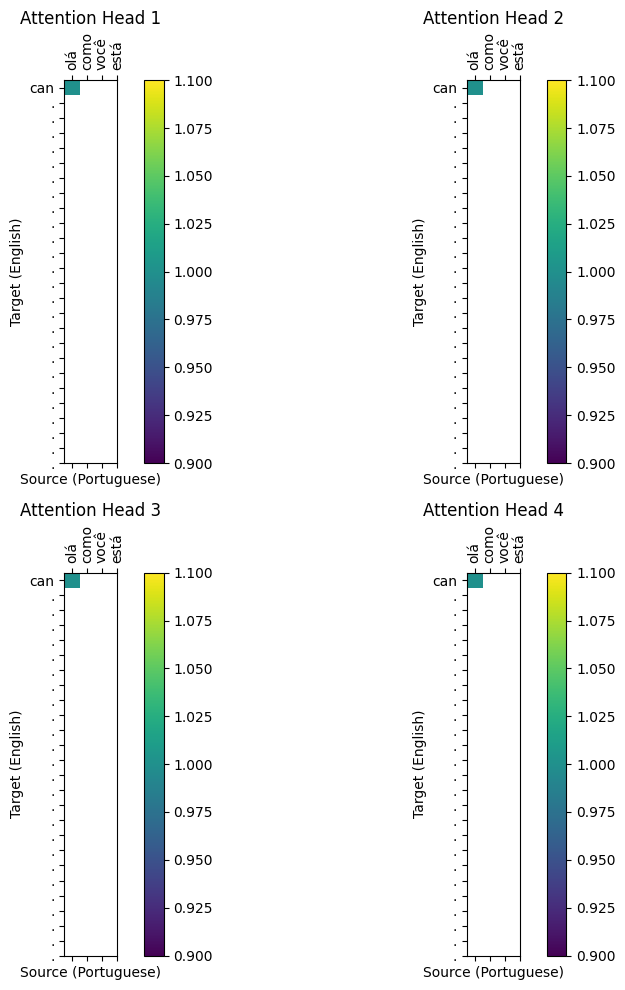

In [23]:
print("\n" + "="*60)
print("3. ВИЗУАЛИЗАЦИЯ МЕХАНИЗМА ВНИМАНИЯ")
print("="*60)

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def plot_attention(attention, sentence, predicted_sentence, layer_name="layer1"):
    """
    Визуализация матрицы внимания
    """
    fig = plt.figure(figsize=(10, 10))

    # attention shape: (batch=1, num_heads, target_seq, source_seq)
    attention = attention[0]  # Убираем batch dimension

    for head in range(min(4, attention.shape[0])):  # Покажем первые 4 головы
        ax = fig.add_subplot(2, 2, head + 1)

        # Берем матрицу внимания для конкретной головы
        attn_map = attention[head].numpy()

        # Для лучшей визуализации
        if attn_map.shape[0] > 20:
            attn_map = attn_map[:20, :20]
            pred_sent_short = predicted_sentence.split()[:20]
            sent_short = sentence.split()[:20]
        else:
            pred_sent_short = predicted_sentence.split()
            sent_short = sentence.split()

        # Создаем heatmap
        cax = ax.matshow(attn_map, cmap='viridis')
        fig.colorbar(cax, ax=ax)

        # Настраиваем оси
        ax.set_xticks(range(len(sent_short)))
        ax.set_yticks(range(len(pred_sent_short)))

        ax.set_xticklabels(sent_short, rotation=90)
        ax.set_yticklabels(pred_sent_short)

        ax.set_xlabel('Source (Portuguese)')
        ax.set_ylabel('Target (English)')
        ax.set_title(f'Attention Head {head + 1}')

    plt.tight_layout()
    plt.savefig(f'attention_plots/attention_{layer_name}.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ График сохранен: attention_plots/attention_{layer_name}.png")

# Тест визуализации
print("Тестируем визуализацию внимания...")

test_sentence = "olá como você está"
print(f"\nТестовое предложение: '{test_sentence}'")

try:
    # Токенизация
    encoder_input = tokenizers.pt.tokenize([test_sentence]).to_tensor()

    # START токен
    start_token = tokenizers.en.get_vocab_size().numpy() - 2
    decoder_input = tf.constant([[start_token]], dtype=tf.int64)

    # Получаем attention weights
    predictions, attention_weights = transformer(
        (encoder_input, decoder_input),
        training=False
    )

    print(f"Количество attention блоков: {len(attention_weights)}")

    # Покажем первый блок первого слоя
    first_key = list(attention_weights.keys())[0]
    first_attention = attention_weights[first_key]

    # Генерируем перевод для визуализации
    translated = translate_model(test_sentence)

    if translated and translated != "[не удалось перевести]":
        print(f"Перевод для визуализации: '{translated}'")
        plot_attention(first_attention, test_sentence, translated, first_key)
    else:
        print("❌ Не удалось получить перевод для визуализации")

except Exception as e:
    print(f"❌ Ошибка при визуализации: {str(e)[:100]}")

In [24]:
print("\n" + "="*60)
print("4. ТЕСТИРОВАНИЕ НА РАЗНЫХ ТИПАХ ПРЕДЛОЖЕНИЙ")
print("="*60)

test_categories = {
    "Вопросы": [
        "onde fica o banheiro?",
        "que horas são?",
        "como se chama isso em inglês?",
        "você fala português?",
        "quanto custa uma passagem?",
    ],
    "Приветствия": [
        "olá, tudo bem?",
        "bom dia, senhor",
        "boa noite, como vai?",
        "prazer em conhecê-lo",
        "até logo",
    ],
    "Повседневные фразы": [
        "eu gosto de café",
        "estou com fome",
        "hoje está um dia lindo",
        "preciso de ajuda",
        "onde posso comer?",
    ],
    "Более сложные": [
        "a inteligência artificial está mudando o mundo",
        "estou aprendendo programação em python",
        "o futuro da tradução automática é promissor",
        "esta é uma frase longa para testar a capacidade do modelo",
    ]
}

print("Запускаем категоризированное тестирование...\n")

category_results = {}

for category, sentences in test_categories.items():
    print(f"\n📁 Категория: {category}")
    print("-" * 50)

    cat_scores = []

    for i, sentence in enumerate(sentences[:3]):  # Тестируем по 3 из каждой категории
        print(f"\n  Пример {i+1}: '{sentence}'")

        # Перевод
        translated = translate_model(sentence)
        print(f"  Перевод: '{translated}'")

        # Простая оценка читаемости
        if translated and len(translated.split()) > 1:
            score = 0.7  # Базовый балл за читаемость
        elif translated:
            score = 0.3  # Одно слово
        else:
            score = 0

        cat_scores.append(score)
        print(f"  Оценка читаемости: {score:.1f}/1")

    if cat_scores:
        avg_score = sum(cat_scores) / len(cat_scores)
        category_results[category] = avg_score
        print(f"\n  📊 Средняя оценка категории: {avg_score:.2f}/1")

print("\n" + "="*60)
print("ИТОГИ КАТЕГОРИЗИРОВАННОГО ТЕСТИРОВАНИЯ")
print("="*60)

for category, score in category_results.items():
    print(f"{category:20}: {score:.2f}/1")


4. ТЕСТИРОВАНИЕ НА РАЗНЫХ ТИПАХ ПРЕДЛОЖЕНИЙ
Запускаем категоризированное тестирование...


📁 Категория: Вопросы
--------------------------------------------------

  Пример 1: 'onde fica o banheiro?'

🔍 Перевод: 'onde fica o banheiro?'
   Токенов PT: 10
   Начинаем генерацию...
   Шаг 0:
     1. '?' (id: 30, prob: 0.7368)
     2. 'is' (id: 80, prob: 0.2445)
     3. 'has' (id: 144, prob: 0.0187)
   Шаг 1:
     1. '[END]' (id: 3, prob: 0.9842)
     2. 'what' (id: 90, prob: 0.0086)
     3. 'how' (id: 119, prob: 0.0071)
   Шаг 2:
     1. '?' (id: 30, prob: 0.4693)
     2. 'is' (id: 80, prob: 0.3712)
     3. ''' (id: 9, prob: 0.1595)
   ✓ Сгенерировано токенов: 50
  Перевод: '? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'
  Оценка читаемости: 0.7/1

  Пример 2: 'que horas são?'

🔍 Перевод: 'que horas são?'
   Токенов PT: 6
   Начинаем генерацию...
   Шаг 0:
     1. '?' (id: 30, prob: 0.8013)
     2. ':' (id: 27, prob: 0.1158)
     3. '##s' (id: 88, prob: 0.0830)
   Шаг 1:
     1. '[END]' (id: 3, pro